In [1]:
import numpy as np
import pandas as pd
from fredmd import FredMD
import sklearn.pipeline as skpipe
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [2]:
from datetime import datetime

In [17]:
chen_z_port_data

,date,port,signalmean,ret,signalname,port_id
1451,1976-03-28,1,-8.060009,2.313661,ChInvIA,ChInvIA1
1452,1976-03-28,2,-0.198874,0.801381,ChInvIA,ChInvIA2
1453,1976-03-28,3,0.276263,2.225419,ChInvIA,ChInvIA3
1454,1976-03-28,4,0.649651,1.597910,ChInvIA,ChInvIA4
1455,1976-03-28,5,7.429058,2.854429,ChInvIA,ChInvIA5
...,...,...,...,...,...,...
740338,2019-08-28,1,-0.252163,-5.243983,FirmAgeMom,FirmAgeMom1
740339,2019-08-28,2,-0.078926,-7.604284,FirmAgeMom,FirmAgeMom2
740340,2019-08-28,3,0.011956,-0.916560,FirmAgeMom,FirmAgeMom3
740341,2019-08-28,4,0.110200,-5.193890,FirmAgeMom,FirmAgeMom4


522

In [42]:
len(portfolios)

772

In [45]:
return_panel.shape

(522, 772)

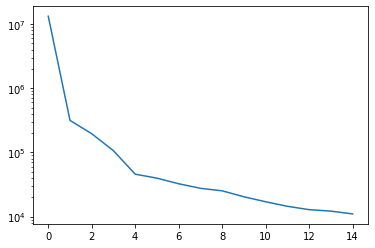

In [49]:
plt.plot(np.linalg.eigh(return_panel.T.dot(return_panel))[0][::-1][:15])
plt.yscale('log')

In [19]:
bond_data = pd.read_csv("bond_data.csv", engine='python', parse_dates=True, infer_datetime_format=True,
                       skiprows=range(1,45), index_col=4)
macro_data = pd.read_csv('https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv',
                         names=spca.transforms.keys(), skiprows=2, index_col=0,
                           skipfooter=1, engine='python', parse_dates=True, infer_datetime_format=True)

In [203]:
help(AutoReg)

Help on class AutoReg in module statsmodels.tsa.ar_model:

class AutoReg(statsmodels.tsa.base.tsa_model.TimeSeriesModel)
 |  Autoregressive AR-X(p) model.
 |  
 |  Estimate an AR-X model using Conditional Maximum Likelihood (OLS).
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      A 1-d endogenous response variable. The dependent variable.
 |  lags : {int, list[int]}
 |      The number of lags to include in the model if an integer or the
 |      list of lag indices to include.  For example, [1, 4] will only
 |      include lags 1 and 4 while lags=4 will include lags 1, 2, 3, and 4.
 |  trend : {'n', 'c', 't', 'ct'}
 |      The trend to include in the model:
 |  
 |      * 'n' - No trend.
 |      * 'c' - Constant only.
 |      * 't' - Time trend only.
 |      * 'ct' - Constant and time trend.
 |  
 |  seasonal : bool
 |      Flag indicating whether to include seasonal dummies in the model. If
 |      seasonal is True and trend includes 'c', then the first period
 |      i

In [338]:
class SPCA:
    
    def __init__(self, data_panel, target_panel, n_train,
                N_factor=6) -> None:
        """
        Auguments:
        1) data_panel: numpy 2d array of data, normalizations and transforms should have already been applied
        2) target_panel: numpy 2d array of target data, normalizations and transforms should have already been applied
        3) n_train: index of start of oos
        4) N_factors: number of factors
        """
        self.n_factors = N_factor
        self.test_start = n_train
        self.data_series = data_panel
        self.tgt_series = target_panel
        
    def fit(self, nlags, true_oos=False, pca=False, raw_data=None,
           stack_lags=False):
        T, _ = self.data_series.shape
        preds = []
        ar_preds = []
        gts = []
        
        
        lags = np.zeros((T, nlags))
        print("target mean", np.mean(self.tgt_series))
        if stack_lags:
            for t in range(nlags, T):
                lags[t] = self.tgt_series[t-nlags:t]
        for t in range(self.test_start, self.tgt_series.shape[0]):
            loadings = SPCA.get_gamma_is(self.data_series[:t,:], self.tgt_series[:t])
            if pca:
                loadings[:] = 1
            loadings = np.diag(loadings)
            if true_oos:
                fit_factors = SPCA.fit_factors(self.data_series[:t,:]@loadings, self.n_factors)
                test_factors = SPCA.fit_factors(self.data_series[:t+1,:]@loadings, self.n_factors)[t:]
            else:
                factors = SPCA.fit_factors(self.data_series[:t+1,:]@loadings, self.n_factors, raw_data=raw_data)
                fit_factors = factors[:t]
                test_factors = factors[t:]
            
            A_fit = np.concatenate([fit_factors, np.ones((t, 1)), lags[:t,:]], axis=1)
            A_test = np.concatenate([test_factors, np.ones((1, 1)), lags[t:t+1,:]], axis=1)
            loadings = np.linalg.lstsq(A_fit, self.tgt_series[:t], rcond=None)[0]
            
            sim_ar_model = AutoReg(self.tgt_series[:t], lags=nlags, old_names=False,
                                  trend='n')
#             sim_ar_model = AutoReg(sim_realized_vol, lags=1, old_names=False)
            sim_ar_model_fit = sim_ar_model.fit()
#             print(sim_ar_model_fit.summary())
            
            gts.append(self.tgt_series[t])
            ar_preds.append(sim_ar_model_fit.forecast())
            preds.append(A_test@loadings)
            
        preds = np.array(preds).squeeze()
        ar_preds = np.array(ar_preds).squeeze()
        print(preds.shape)
        gts = np.array(gts)
        print(gts.shape)
        plt.plot(preds - gts, label='factor resids')
        plt.plot(ar_preds - gts, label='ar resids')
        plt.legend()
        plt.show()
        
        print("r2 vs ar model", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts - ar_preds)))
        print("r2 vs mean model", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts - np.mean(gts))))
        print("EV", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts)))
        

        
    def fit_ts_reg(self):
        self.test_start
        gamma_is = SPCA.get_gamma_is(self.data_series[:self.test_start,:], self.tgt_series[:self.test_start])
        factors = SPCA.fit_factors(self.data_series*gamma_is, self.n_factors)[self.test_start:]
        loadings = np.linalg.lstsq(factors, self.tgt_series[self.test_start:], rcond=None)[0]
        preds = factors.dot(loadings)
        gts = self.tgt_series[self.test_start:]
        print(preds.shape)
        print(gts.shape)
        plt.plot(preds - gts, label='factor resids')
        plt.legend()
        plt.show()
        
        print("r2 vs mean model", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts - np.mean(gts))))
        print("EV", 1 - np.sum(np.square(preds - gts)) / np.sum(np.square(gts)))
    

    @staticmethod
    def fit_factors(scaled_data, n_factors, raw_data = None):
        T,N = scaled_data.shape
        if raw_data is None:
            demeaned_data = scaled_data - np.mean(scaled_data, axis=0, keepdims=True)
            evals, evects = np.linalg.eigh((1/N)*demeaned_data.dot(demeaned_data.T))
            evects = evects[:,::-1]
            factors = evects[:,:n_factors]
            loadings = np.linalg.lstsq(factors, demeaned_data, rcond=None)[0]
        else:
            evals, evects = np.linalg.eigh(scaled_data.T.dot(scaled_data))
            evects = evects[:,::-1]
            lmbda = evects[:,:n_factors]
            factors = (1/N) * raw_data[:T]@lmbda
#         for k in range(n_factors):
#             plt.bar(np.arange(N), loadings[k,:])
#             plt.show()
            
        return factors
        
    
    @staticmethod
    def get_gamma_is(data, target):
        loadings = []
        T = target.shape[0]
        data_copy = np.copy(data) - np.mean(data, axis=0, keepdims=True)
        
        for i in range(data_copy.shape[1]):
            A = np.stack([data_copy[:,i], np.ones(T)], axis=1)
            loading = np.linalg.lstsq(A, target, rcond=None)[0][0]
            loadings.append(loading)
        return np.array(loadings)

    

0.001291250834995143
target mean 0.001293051742714802
(418,)
(418,)


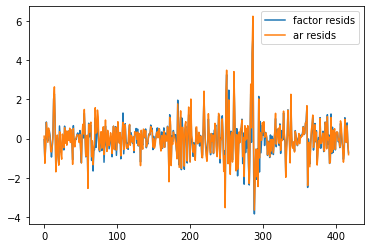

r2 vs ar model 0.07604497866431148
r2 vs mean model 0.1838012812835853
EV 0.18380323837889323
target mean 0.001293051742714802
(418,)
(418,)


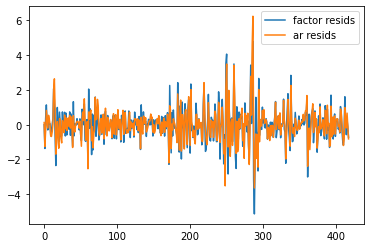

r2 vs ar model -0.19324316533575492
r2 vs mean model -0.05408111885818667
EV -0.05407859136437332


In [343]:
# VXOCLSx UNRATE INDPRO CPIAUCSL
spca_data = SPCAData(target=f'CPIAUCSL')
data_panel, tgt_data, test_start, raw_data = spca_data.get_data()
spca = SPCA(data_panel, tgt_data, test_start, N_factor=4)
spca.fit(4, stack_lags=True)
spca.fit(4, pca=True)

In [341]:
class SPCAData:
    
    def __init__(self, Nfactor=None, vintage=None, maxfactor=8, standard_method=2, ic_method=2,
                 target=None, train_test_split=[('1960-01-01', '1984-12-01'),('1985-01-01', '2019-12-01')], 
                 nlags=1) -> None:
        """
        Create fredmd object
        Auguments:
        1) Nfactor = None: Number of factors to estimate. If None then estimate number of true factors via information critea
        2) vintage = None: Vinatege of data to use in "year-month" format (e.g. "2020-10"). If None use current vintage
        3) maxfactor = 8: Maximimum number of factors to test against information critea. If Nfactor is a number, then this is ignored
        4) standard_method = 2: method to standardize data before factors are estimate. 0 = Identity transform, 1 = Demean only, 2 = Demean and stardize to unit variance. Default = 2.
        5) ic_method = 2: information critea penalty term. Se
        e http://www.columbia.edu/~sn2294/pub/ecta02.pdf page 201, equation 9 for options.
        """
        
        self.train_test_split = [[datetime.strptime(x, '%Y-%m-%d') for x in split] for split in train_test_split]
        # Make sure arguments are valid
        if standard_method not in [0, 1, 2]:
            raise ValueError(f"standard_method must be in [0, 1, 2], got {standard_method}")
        if ic_method not in [1, 2, 3]:
            raise ValueError(f"ic_method must be in [1, 2, 3], got {ic_method}")
        # Download data
        self.rawseries, self.transforms, self.target, self.train_mask, self.test_mask = self.download_data(vintage, 
                                                                       target if target is not None else "UNRATE",
                                                                         self.train_test_split)
        

        self.target_name = target
        self.standard_method = standard_method
        self.ic_method = ic_method
        self.maxfactor = maxfactor
        self.Nfactor = Nfactor

        self.nlags = nlags

    @staticmethod
    def download_data(vintage, tgt, train_test_split):
        if vintage is None:
            url = 'https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv'
        else:
            url = f'https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/{vintage}.csv'
        transforms = pd.read_csv(
            url, header=0, nrows=1, index_col=0).transpose()
        transforms.index.rename("series", inplace=True)
        transforms.columns = ['transform']
        transforms = transforms.to_dict()['transform']
        data = pd.read_csv(url, names=transforms.keys(), skiprows=2, index_col=0,
                           skipfooter=1, engine='python', parse_dates=True, infer_datetime_format=True)
        
        data = data.loc[data.index >= '1960-01-01']
        data = data.loc[data.index < '2020-01-01']
        
        train_mask = (data.index > train_test_split[0][0]) & (data.index <= train_test_split[0][1])
        test_mask = (data.index > train_test_split[1][0]) & (data.index <= train_test_split[1][1])
        
        target = None
        if "FB-yeild" in tgt:
            bond_data = pd.read_csv("bond_data.csv", engine='python', parse_dates=True, infer_datetime_format=True,
                       skiprows=range(1,45), index_col=4)
            if tgt == 'FB-yeild-1':
                bond_data = bond_data.loc[bond_data['TTERMTYPE'] == 5001]
            elif tgt == 'FB-yeild-2':
                bond_data = bond_data.loc[bond_data['TTERMTYPE'] == 5002]
            elif tgt == 'FB-yeild-3':
                bond_data = bond_data.loc[bond_data['TTERMTYPE'] == 5003]
            elif tgt == 'FB-yeild-4':
                bond_data = bond_data.loc[bond_data['TTERMTYPE'] == 5004]
            elif tgt == 'FB-yeild-5':
                bond_data = bond_data.loc[bond_data['TTERMTYPE'] == 5005]
            bond_data.index = bond_data.index.to_period('M') 
            intersection = bond_data.index.intersection(data.index.to_period('M'))
            target = bond_data[bond_data.index.isin(intersection)]["TMYTM"]
            
        return data, transforms, target, train_mask, test_mask

    @staticmethod
    def factor_standardizer_method(code):
        """
        Outputs the sklearn standard scaler object with the desired features
        codes:
        0) Identity transform
        1) Demean only
        2) Demean and standardized
        """
        if code == 0:
            return skp.StandardScaler(with_mean=False, with_std=False)
        elif code == 1:
            return skp.StandardScaler(with_mean=True, with_std=False)
        elif code == 2:
            return skp.StandardScaler(with_mean=True, with_std=True)
        else:
            raise ValueError("standard_method must be in [0, 1, 2]")

    @staticmethod
    def data_transforms(series, transform):
        """
        Transforms a single series according to its transformation code
        Inputs:
        1) series: pandas series to be transformed
        2) transfom: transform code for the series
        Returns:
        transformed series
        """
        if transform == 1:
            # level
            return series
        elif transform == 2:
            # 1st difference
            return series.diff()
        elif transform == 3:
            # second difference
            return series.diff().diff()
        elif transform == 4:
            # Natural log
            return np.log(series)
        elif transform == 5:
            # log 1st difference
            return np.log(series).diff()
        elif transform == 6:
            # log second difference
            return np.log(series).diff().diff()
        elif transform == 7:
            # First difference of percent change
            return series.pct_change().diff()
        else:
            raise ValueError("Transform must be in [1, 2, ..., 7]")

    def apply_transforms(self):
        """
        Apply the transformation to each series to make them stationary and drop the first 2 rows that are mostly NaNs
        Save results to self.series
        """
        self.series = pd.DataFrame({key: self.data_transforms(
            self.rawseries[key], value) for (key, value) in self.transforms.items()})

    def remove_outliers(self):
        """
        Removes outliers from each series in self.series
        Outlier definition: a data point x of a series X is considered an outlier if abs(x-median)>10*interquartile_range.
        """
        Z = abs((self.series - self.series.median()) /
                (self.series.quantile(0.75) - self.series.quantile(0.25))) > 10
        for col, _ in self.series.iteritems():
            self.series[col][Z[col]] = np.nan
        

    def get_data(self):
        """
        """
        # Define our estimation pipelines
        self.apply_transforms()
        self.remove_outliers()
        
        pipe = skpipe.Pipeline([('Standardize', self.factor_standardizer_method(self.standard_method))])
#         inital_scalar = self.factor_standardizer_method(self.standard_method)

        # Make numpy arrays for calculations
        actual_data = self.series.to_numpy(copy=True)
        intial_nas = self.series.isna().to_numpy(copy=True)
        working_data = self.series.fillna(value=self.series.mean(), axis='index').to_numpy(copy=True)
#         working_data = self.series.fillna(value=0).to_numpy(copy=True)
        
#         initial_scalar = self.factor_standardizer_method(self.standard_method)
#         initial_scalar = initial_scalar.fit(self.series.fillna(
#             value=self.series.mean(), axis='index').to_numpy(copy=True)[self.train_mask])
#         working_data = initial_scalar.transform(self.series.fillna(
#             value=self.series.mean(), axis='index').to_numpy(copy=True))
        
        
        last_timestep = np.sum(self.train_mask) + np.sum(self.test_mask)
        
        transformed_normalized_data = pipe.fit_transform(working_data)
#         return_data = working_data[:last_timestep]        
        return_data = transformed_normalized_data[:last_timestep]        

        if self.target is None:
            idx = self.series.columns.get_loc(self.target_name)
            target_data = transformed_normalized_data[:last_timestep,idx]
            print(np.mean(target_data))
        else:
            target_data = self.target
        
        
        
        
        return return_data[:-1],  target_data[1:], np.sum(self.train_mask), working_data[:last_timestep]
        


In [156]:
class ChenZData:
    
    def __init__(self, start_date='1976-03', end_date='2019-09', tgt_factor='mkt'):
        chen_z_port_data = pd.read_csv("allportretbase.csv", engine='python', 
                                       parse_dates=True, infer_datetime_format=True,
                               index_col=0)
        chen_z_port_data = chen_z_port_data.loc[chen_z_port_data.date >= start_date]
        chen_z_port_data = chen_z_port_data.loc[chen_z_port_data.date < end_date]

        chen_z_port_data['port_id'] = chen_z_port_data.signalname.add(chen_z_port_data.port.astype(str))
        chen_z_port_data.port_id = chen_z_port_data.port_id
        portfolios = sorted(chen_z_port_data.port_id.unique())
        dates = chen_z_port_data.date.unique()
        portfolios = [p for p in portfolios if 
                     np.sum(chen_z_port_data['port_id'] == p) == len(dates)]
        return_panel = np.zeros((len(dates), len(portfolios)), dtype=float)
        for i, pname in enumerate(portfolios):
            return_panel[:, i] = chen_z_port_data.loc[chen_z_port_data['port_id'] == pname].ret.to_numpy()
        tgt = None
        if tgt_factor in {'mkt', 'SMB', 'HML', 'CMA', 'RMW'}:
            int_start_date = int(start_date.replace('-', ''))
            int_end_date = int(end_date.replace('-', ''))
            ff_factors = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=0,
                                       engine='python', parse_dates=True, infer_datetime_format=True)
            ff_factors = ff_factors.loc[ff_factors.date >= int_start_date] #NOTE not offsetting by one here across data sources
            ff_factors = ff_factors.loc[ff_factors.date < int_end_date]
            if tgt_factor == 'mkt':
                tgt = ff_factors['Mkt-RF'].to_numpy()
            if tgt_factor == 'SMB':
                tgt = ff_factors['SMB'].to_numpy()
            if tgt_factor == 'HML':
                tgt = ff_factors['HML'].to_numpy()
            if tgt_factor == 'CMA':
                tgt = ff_factors['CMA'].to_numpy()
            if tgt_factor == 'RMW':
                tgt = ff_factors['RMW'].to_numpy()
        self.data = return_panel, tgt, int(tgt.shape[0]/2)

In [149]:
for tgt in 'mkt', 'SMB', 'HML', 'CMA', 'RMW' :
    chen_z_data_panel, mkt_return, weak_test_start = ChenZData(tgt_factor=tgt).data
    spca = SPCA(chen_z_data_panel, mkt_return, weak_test_start)
    spca.fit_ts_reg()
    print()

FileNotFoundError: [Errno 2] No such file or directory: 'allportretbase.csv'

In [150]:
#unemp 4 lags indpro 5

(717, 128) (717,)
(419,)
(419,)


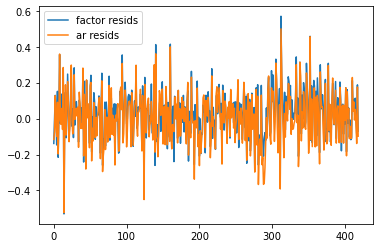

r2 vs ar model 0.04744581689598448
r2 vs mean model 0.1382632531211948
EV 0.14096651846356534


In [137]:
spca_data = SPCAData(target=f'UNRATE')
data_panel, tgt_data, test_start = spca_data.get_data()
spca = SPCA(data_panel, tgt_data, test_start, N_factor=1)
spca.fit(4)

(717, 128) (717,)
(419,)
(419,)


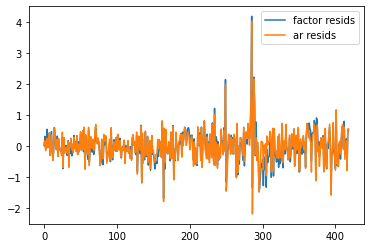

r2 vs ar model -0.012429822245483502
r2 vs mean model 0.10030119870593546
EV 0.1455882741641904


In [142]:
spca_data = SPCAData(target=f'INDPRO')
data_panel, tgt_data, test_start = spca_data.get_data()
spca = SPCA(data_panel, tgt_data, test_start, N_factor=4)
spca.fit(4)

(717, 128) (717,)
(419,)
(419,)


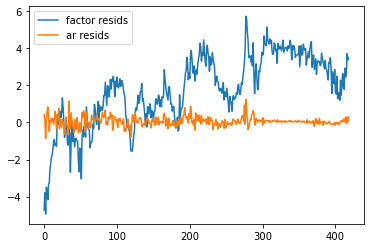

r2 vs ar model -96.47640779665552
r2 vs mean model 0.07473158100562105
EV 0.6802190563403514


In [23]:
spca = SPCA(target=f'FB-yeild-{1}', Nfactor=5, nlags=1)
spca.factors_em()

In [117]:
data_panel, tgt_data, test_start = spca_data(target='UNRATE').get_data()
spca = SPCA(data_panel, tgt_data, test_start)
spca.fit(1)

TypeError: 'SPCAData' object is not callable

In [114]:
spca = SPCA(target='UNRATE', Nfactor=1, nlags=2)
spca.factors_em()

TypeError: __init__() got an unexpected keyword argument 'target'

nans everywhere 0
(717, 128) (717,)
(419,)
(419,)


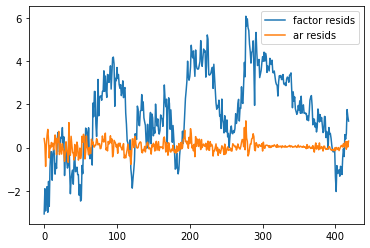

r2 vs ar model -84.38976502134294
r2 vs mean model 0.18946076629723396
EV 0.7198704768197501


In [20]:
spca = SPCA(target=f'FB-yeild-{1}', Nfactor=5, nlags=1)
spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
                  RPI  W875RX1  DPCERA3M086SBEA     CMRMTSPLx       RETAILx  \
1959-01-01   2437.296   2288.8           17.302  2.922588e+05   18235.77392   
1959-02-01   2446.902   2297.0           17.482  2.944295e+05   18369.56308   
1959-03-01   2462.689   2314.0           17.647  2.934254e+05   18523.05762   
1959-04-01   2478.744   2330.3           17.584  2.993317e+05   18534.46600   
1959-05-01   2493.228   2345.8           17.796  3.013730e+05   18679.66354   
...               ...      ...              ...           ...           ...   
2020-08-01  17663.582  13961.2          117.335  1.554439e+06  543404.00000   
2020-09-01  17770.773  14101.1          118.656  1.564146e+06  552767.00000   
2020-10-01  17645.314  14197.3          118.934  1.573161e+06  552193.00000   
2020-11-01  17415.377  14088.2          118.123  1.568472e+06  544641.00000   
2020-12-01  17445.537  14056.6          117.398     

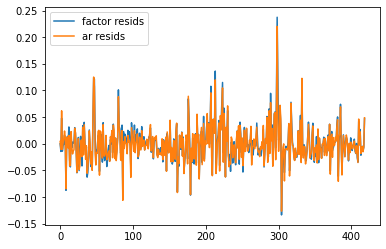

-0.06725889664666562


In [295]:
spca = SPCA(target='S&P 500', Nfactor=8, nlags=1)
spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


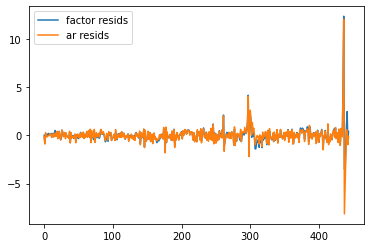

0.19207638719839615
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


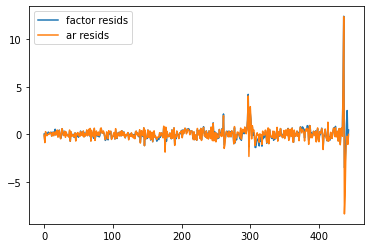

0.22163184584411622
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


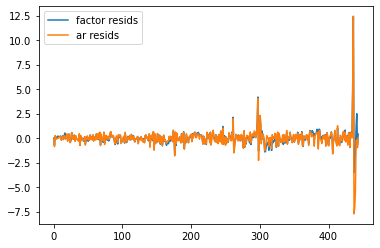

0.2546626056369228
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(444,)
(444,)


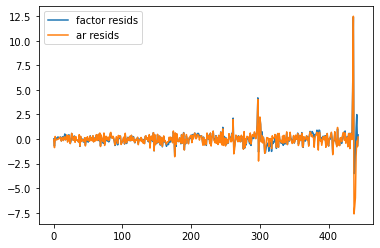

0.26165434703830004


In [288]:
for i in range(1,5):
    spca = SPCA(target='INDPRO', Nfactor=5, nlags=i)
    spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


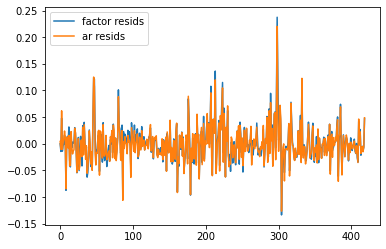

-0.06725889664666562


In [293]:
spca = SPCA(target='S&P 500', Nfactor=8, nlags=1)
spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


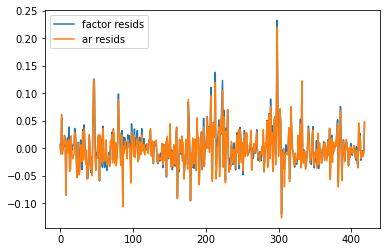

-0.0545901909921267
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


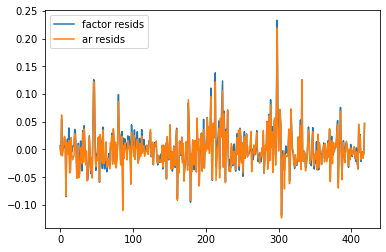

-0.05734832273825896
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


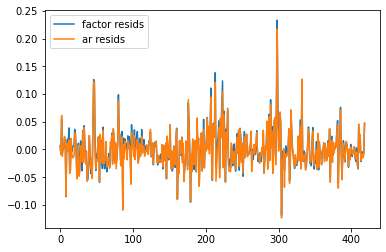

-0.05659311178749693
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


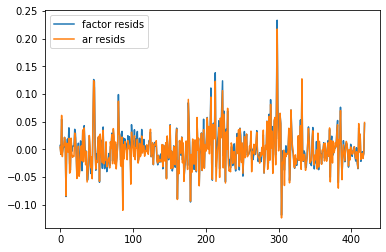

-0.05518135773328203


In [291]:
for i in range(1,5):
    spca = SPCA(target='S&P 500', Nfactor=5, nlags=i)
    spca.factors_em()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


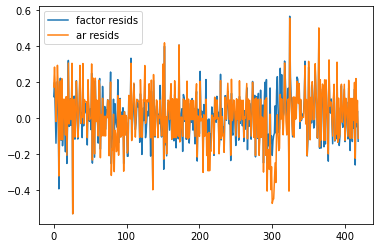

0.17968552452051945
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


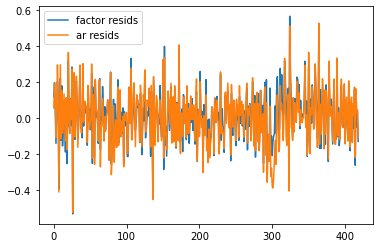

0.15295146785616398
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


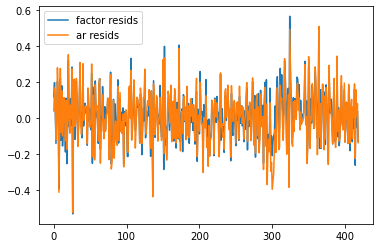

0.11409461541200283
https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv
DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=744, freq=None)
(741, 128) (741,)
(419,)
(419,)


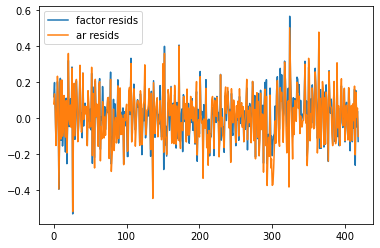

0.08904476184994436


In [286]:
for i in range(1,5):
    spca = SPCA(target='UNRATE', Nfactor=5, nlags=i)
    spca.factors_em()

(419,)
(419,)


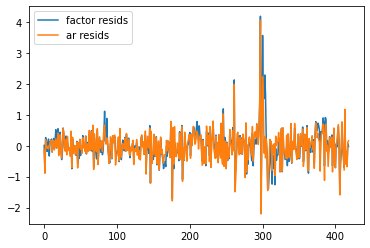

1.1511049805308506


In [261]:
spca.estimate_factors()

In [51]:
fred = FredMD()
fred.apply_transforms()
fred.remove_outliers()

https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/monthly/current.csv


In [47]:
fred.Nfactor = 10

In [53]:
pipe = skpipe.Pipeline([('Standardize', fred.factor_standardizer_method(fred.standard_method)),
#                        ('Factors', skd.TruncatedSVD(fred.Nfactor, algorithm='arpack'))
                       ])
actual_data = fred.series.to_numpy(copy=True)
intial_nas = fred.series.isna().to_numpy(copy=True)
inital_scalar = fred.factor_standardizer_method(fred.standard_method)
working_data = inital_scalar.fit_transform(fred.series.fillna(value=fred.series.mean(), 
                                                              axis='index').to_numpy(copy=True))
data = pipe.fit_transform(working_data)

In [56]:
data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [57]:
eig_vals, eig_vects = np.linalg.eigh(standardized_data.T.dot(standardized_data))

In [61]:
eig_vals / np.sum(np.sum(eig_vals))

array([2.97965257e-07, 2.39278045e-06, 4.02957477e-06, 7.54408789e-06,
       8.75060145e-06, 1.34836161e-05, 1.49403480e-05, 1.82120372e-05,
       2.02276488e-05, 2.08989927e-05, 2.37548150e-05, 3.43286195e-05,
       4.73844401e-05, 5.09838978e-05, 5.44298063e-05, 8.73096264e-05,
       8.79316945e-05, 1.06109755e-04, 1.15320997e-04, 1.25272737e-04,
       1.33914087e-04, 1.58441904e-04, 1.70246149e-04, 2.16338508e-04,
       2.25279789e-04, 2.43188657e-04, 2.71799304e-04, 2.86879126e-04,
       3.08745339e-04, 3.26165190e-04, 3.70156279e-04, 3.94748709e-04,
       4.09264088e-04, 4.13690088e-04, 4.71690193e-04, 4.92526268e-04,
       5.35951731e-04, 5.62665728e-04, 5.82337018e-04, 6.43025749e-04,
       6.78708567e-04, 7.83484743e-04, 8.20438633e-04, 8.46733779e-04,
       8.65212383e-04, 9.79524846e-04, 1.00014017e-03, 1.05328578e-03,
       1.08172866e-03, 1.13643886e-03, 1.19671447e-03, 1.26478821e-03,
       1.31526694e-03, 1.48000765e-03, 1.54115947e-03, 1.57587893e-03,
      